In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image

In [2]:
# Path to file (for Colab)
PATH = ""

# Dataset
<a href="https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data">Amazon Dataset</a>

# Data Understanding

In [3]:
# See the shape of all images:
# Main Directory
main_path = PATH + 'AmazonDataset/'


def get_size(folder):
    sizes = []
    # Get from main directory all sub-directories
    for folder_path in os.listdir(folder):
        # Skip
        if (folder_path == '.DS_Store'):
            continue
        # See Train and Test sub-directories
        for folder_name in os.listdir(os.path.join(folder, folder_path)):
            # Skip
            if (folder_name in ['.DS_Store', 'test_v2_file_mapping.csv', 'train_v2.csv']):
                continue
            print(folder_name)
            for filename in os.listdir(os.path.join(folder, folder_path, folder_name)):
                
                # take image
                img = Image.open(os.path.join(folder, folder_path, folder_name, filename))
                # Get image with 
                #print(img.size)
                # Stores data like: (width, height)
                sizes.append(img.size)
            
    print(f'the max width is: {max(sizes[0])}, and the min width is: {min(sizes[0])}')
    print(f'the max height is: {max(sizes[1])}, and the min height is: {min(sizes[1])}')
    print(f'the mean width is: {np.mean(sizes[0])}, and the mean height is: {np.mean(sizes[1])}')

# Call the function
get_size(main_path)

test-jpg
train-jpg
the max width is: 256, and the min width is: 256
the max height is: 256, and the min height is: 256
the mean width is: 256.0, and the mean height is: 256.0


In [4]:
train_path = PATH + 'AmazonDataset/Train/'
test_path = PATH + 'AmazonDataset/Test/'

## See Images

In [5]:
images_folder_train = train_path + '/train-jpg/'
images_folder_test = test_path + '/test-jpg/'

In [6]:
import matplotlib.pyplot as plt
def plot_images(axis=(2,2), images_folder_path=images_folder_train, train = True):
    
    if train:
        train = 'train_'
    else:
        train = 'test_'
        
    # Grid
    f, axarr = plt.subplots(axis[0], axis[1], figsize=(30/axis[1], 10))
    
    for i in range(0,axis[0]):
        for j in range (0,axis[1]):
            # Choose a random image
            index_img = np.random.randint(100)
            filename = images_folder_path + train + str(index_img) + '.jpg'
            # Read Image:
            img = Image.open(filename).convert('RGB')
            # To numpy
            img = np.asarray(img)
            # Plot
            axarr[i,j].imshow(img)
    plt.show()

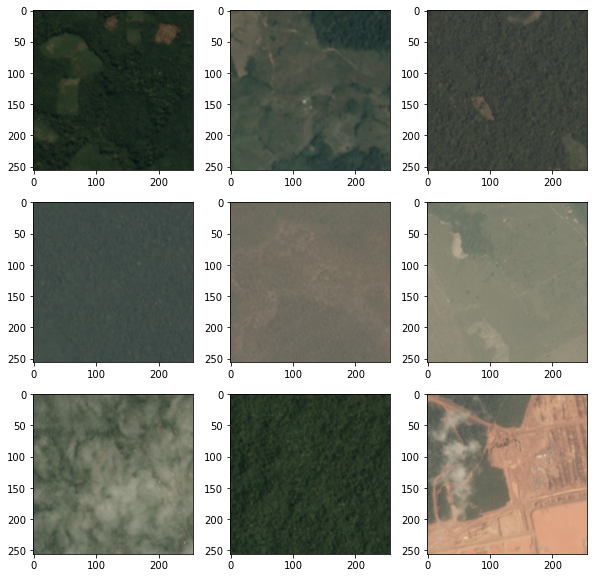

In [7]:
plot_images(axis=(3,3), images_folder_path=images_folder_train)

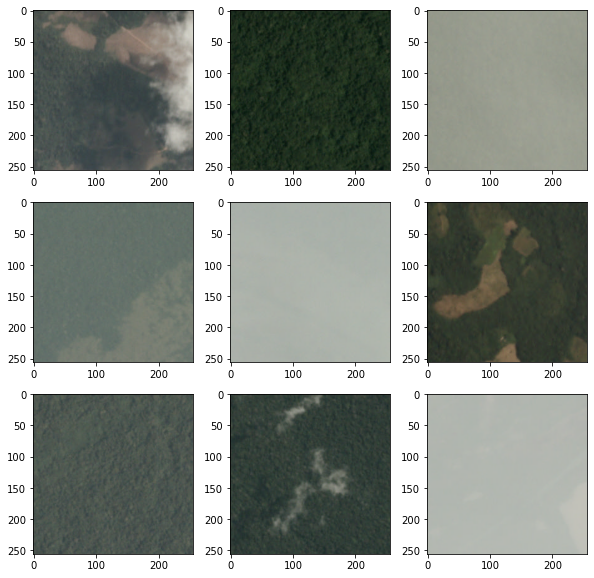

In [8]:
plot_images(axis=(3,3), images_folder_path=images_folder_test, train=False)

## See Labels

In [9]:
train_path_labels = train_path + 'train_v2.csv'
test_path_labels = test_path + 'test_v2_file_mapping.csv'

In [10]:
# Train Images and labels
train_map = pd.read_csv(train_path_labels)
train_map

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [11]:
pd.read_csv(test_path_labels)

,old,new
0,file_4158.tif,file_18830.tif
1,file_1668.tif,file_19164.tif
2,file_2411.tif,file_15749.tif
3,file_16047.tif,file_7531.tif
4,file_1271.tif,file_18347.tif
...,...,...
20517,file_17774.tif,file_14520.tif
20518,file_3538.tif,file_6633.tif
20519,file_1923.tif,file_4685.tif
20520,file_14047.tif,file_14571.tif


# Create Dataset
* This is a multi labels task, so we need binary encode the tags
* We don't have labels for testing images so we need to split data of train in train and test
* We have many information so we need a data loader to wrap-up the data and avoid overload the GPU or RAM

## Binary Encode

In [12]:
tags_encode = train_map.tags.str.get_dummies(sep=' ').columns
tags_encode

Index(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down',
       'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation',
       'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging',
       'slash_burn', 'water'],
      dtype='object')

In [13]:
# Select Tags
list_tags = ['agriculture', 'bare_ground', 'cultivation', 'habitation', 'primary', 'road', 'water']

## Filter images with tags 
* We have many tags, but we just want images with tags in list_tags so we filter

In [14]:
def filter_item(tag_string):
    res = any(tag in tag_string for tag in list_tags)
    return res    

In [15]:
train_map = train_map[train_map.tags.apply(lambda tag_string: filter_item(tag_string))]
train_map

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40473,train_40473,agriculture clear habitation primary road
40474,train_40474,clear primary
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


## Binary Encode and desired columns 

In [16]:
# Binary Encode
encode = train_map.tags.str.get_dummies(sep=' ')
train_map = pd.concat([train_map, encode], axis=1)
train_map.drop(columns=["tags"], inplace=True)
list_tags.insert(0,'image_name')
train_map = train_map[list_tags]
list_tags.pop(0)
train_map

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
0,train_0,0,0,0,0,1,0,0
1,train_1,1,0,0,0,1,0,1
2,train_2,0,0,0,0,1,0,0
3,train_3,0,0,0,0,1,0,0
4,train_4,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...
40473,train_40473,1,0,0,1,1,1,0
40474,train_40474,0,0,0,0,1,0,0
40476,train_40476,1,0,0,0,1,0,0
40477,train_40477,1,0,0,0,1,1,0


### Add ".jpg" to image name

In [17]:
train_map.image_name = train_map.image_name.apply(lambda name: name + '.jpg')
train_map

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
0,train_0.jpg,0,0,0,0,1,0,0
1,train_1.jpg,1,0,0,0,1,0,1
2,train_2.jpg,0,0,0,0,1,0,0
3,train_3.jpg,0,0,0,0,1,0,0
4,train_4.jpg,1,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...
40473,train_40473.jpg,1,0,0,1,1,1,0
40474,train_40474.jpg,0,0,0,0,1,0,0
40476,train_40476.jpg,1,0,0,0,1,0,0
40477,train_40477.jpg,1,0,0,0,1,1,0


the images with agriculture are 12315
the images with bare_ground are 862
the images with cultivation are 4477
the images with habitation are 3660
the images with primary are 37513
the images with road are 8071
the images with water are 7411


<AxesSubplot:>

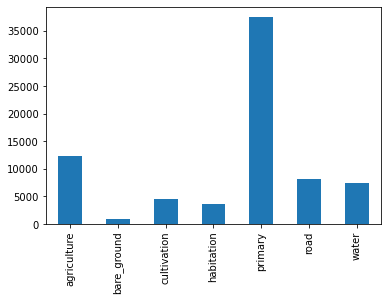

In [18]:
for item in list_tags:
    print(f'the images with {item} are {len(train_map[train_map[item] == 1])}')

train_map[list_tags].sum().plot.bar()

# Train, Test, Validation Split

In [19]:
from sklearn.model_selection import train_test_split

# Split Train and test
train, test = train_test_split(train_map, test_size=0.2, random_state=1)

# Split Train and validation
train, validation = train_test_split(train_map, test_size=0.1, random_state=1)

In [20]:
train

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
23491,train_23491.jpg,1,0,0,0,1,0,1
6046,train_6046.jpg,1,0,0,0,1,1,0
8878,train_8878.jpg,1,0,1,0,1,0,0
26987,train_26987.jpg,1,0,0,0,1,0,0
4478,train_4478.jpg,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
8247,train_8247.jpg,0,0,0,0,1,0,0
34311,train_34311.jpg,0,0,0,0,1,1,1
5486,train_5486.jpg,0,0,0,0,1,0,0
12866,train_12866.jpg,1,0,0,0,1,0,0


In [21]:
test

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
16249,train_16249.jpg,1,0,0,0,1,1,0
37026,train_37026.jpg,1,0,0,1,1,1,1
4720,train_4720.jpg,1,0,1,0,1,0,0
7175,train_7175.jpg,1,0,0,0,1,1,0
6325,train_6325.jpg,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...
27230,train_27230.jpg,0,0,0,0,1,0,0
7530,train_7530.jpg,1,1,0,0,1,1,1
33024,train_33024.jpg,0,0,0,0,1,0,0
18737,train_18737.jpg,0,0,0,0,1,0,0


In [22]:
validation

,image_name,agriculture,bare_ground,cultivation,habitation,primary,road,water
16249,train_16249.jpg,1,0,0,0,1,1,0
37026,train_37026.jpg,1,0,0,1,1,1,1
4720,train_4720.jpg,1,0,1,0,1,0,0
7175,train_7175.jpg,1,0,0,0,1,1,0
6325,train_6325.jpg,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...
22221,train_22221.jpg,0,0,0,0,1,0,0
29893,train_29893.jpg,1,0,0,1,1,1,0
35028,train_35028.jpg,0,0,0,0,1,1,0
24796,train_24796.jpg,0,0,0,0,1,0,0


# Creating data Generator and Data Augmentation

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# We can't load all data in memory at once, so we use a DataGenerator
#Create instance of ImageDataGenerator Class
image_gen_train = ImageDataGenerator(
                    # Rescale
                    rescale=1./255,
                    # Rotate 30
                    rotation_range=30,
                    # Shift pixel values
                    width_shift_range=.15,
                    height_shift_range=.15,
                    # Flip all image
                    horizontal_flip=True,
                    # Random zoom
                    zoom_range=0.4
                    )
image_gen_test = ImageDataGenerator(rescale=1./255)
image_gen_valid = ImageDataGenerator(rescale=1./255)

Init Plugin
Init Graph Optimizer
Init Kernel


In [24]:
width = 256 # width = height
batch_size = 16

# Custom datagenerator
train_datagen = image_gen_train.flow_from_dataframe(dataframe=train,
                                                    directory=images_folder_train,
                                                    x_col='image_name',
                                                    y_col=list_tags,
                                                    batch_size=batch_size, #16,32,64...
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="raw",
                                                    target_size=(width,width))
                                                                
test_datagen = image_gen_test.flow_from_dataframe(dataframe=test,
                                                    directory=images_folder_train,
                                                    x_col='image_name',
                                                    y_col=list_tags,
                                                    batch_size=batch_size, #16,32,64...
                                                    seed=1,
                                                    shuffle=False,
                                                    class_mode="raw",
                                                    target_size=(width,width))

valid_datagen = image_gen_valid.flow_from_dataframe(dataframe=validation,
                                                    directory=images_folder_train,
                                                    x_col='image_name',
                                                    y_col=list_tags,
                                                    batch_size=batch_size, #16,32,64...
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="raw",
                                                    target_size=(width,width))



Found 34548 validated image filenames.
Found 7678 validated image filenames.
Found 3839 validated image filenames.


In [25]:
import matplotlib.pyplot as plt
def plot_images_datagen(axis=(2,2), images=None):

    # Grid
    f, axarr = plt.subplots(axis[0], axis[1], figsize=(30/axis[1], 10))
    index = 0
    for i in range(0,axis[0]):
        for j in range (0,axis[1]):
            # Plot
            axarr[i,j].imshow(images[index])
            index += 1
    plt.show()

Found 3839 validated image filenames.


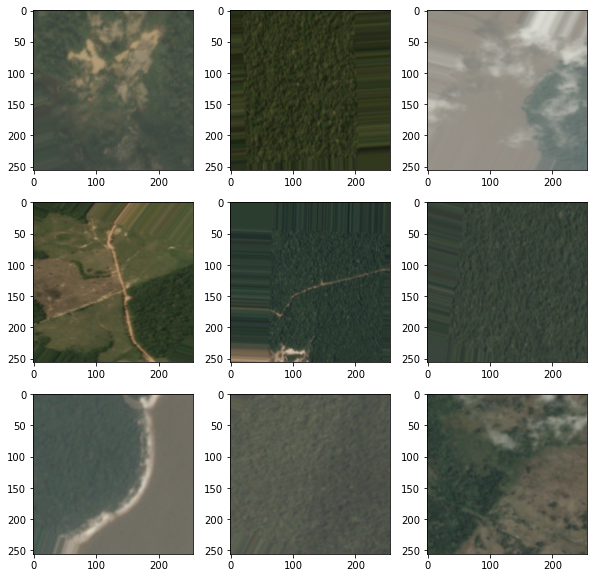

In [26]:
# See Example of image datagenerator
example = image_gen_train.flow_from_dataframe(dataframe=validation,
                                                    directory=images_folder_train,
                                                    x_col='image_name',
                                                    y_col=list_tags,
                                                    batch_size=batch_size, #16,32,64...
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="raw",
                                                    target_size=(width,width))

images, _ = next(example)
example_images = images[:9]
plot_images_datagen(axis=(3,3), images=example_images)

# Create Model
* <a href="https://arxiv.org/abs/2104.05704">Convolutional Compact Transformer CCT </a>

In [27]:
# See if GPU is aviable
import tensorflow as tf

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Compact Convolutional Visual Transformer

### Configure the hyperparameters

In [28]:
num_classes = len(list_tags)
input_shape = (256, 256, 3)

In [29]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 100
image_size = 256

In [30]:
from tensorflow.keras import layers

### CCT tokenizer

In [31]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

### Stochastic depth for regularization

In [32]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

### MLP

In [33]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Build CCT

Architecture:
<img src="https://miro.medium.com/max/2000/1*8diH01Fl7MhHRemLy9hUHw.png">


In [34]:
from tensorflow import keras
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes, activation='sigmoid')(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Create model

In [35]:
np.random.seed(1)
tf.random.set_seed(1234)

model = create_cct_model()
model.summary()

Metal device set to: Apple M1


2021-10-05 14:45:42.721715: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-05 14:45:42.722271: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
cct_tokenizer (CCTTokenizer)    (None, None, None)   75456       input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 4096, 128)    0           cct_tokenizer[0][0]              
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 4096, 128)    256         tf.__operators__.add[0][0]       
______________________________________________________________________________________________

# Compile the Model

In [36]:

"""
optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)
"""

model.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy',
    metrics = ['categorical_accuracy','accuracy'],
)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_filepath = "Models/ConvViT/tmp/checkpoint"

keras_callbacks   = [
    # EarlyStopping:
    EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                  verbose=1, mode='auto', restore_best_weights=True),
    # ModelCheckpoint
    ModelCheckpoint(checkpoint_filepath, monitor="val_loss", 
                    save_best_only=True, save_weights_only=True,)
]

## Fit

In [ ]:
STEP_SIZE_TRAIN = train_datagen.n//train_datagen.batch_size
STEP_SIZE_VALID = valid_datagen.n//valid_datagen.batch_size
STEP_SIZE_TEST = test_datagen.n//test_datagen.batch_size

# https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/Model#fit
history = model.fit(
    x = train_datagen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_datagen,
    validation_steps=STEP_SIZE_VALID,
    epochs=num_epochs,
    callbacks=keras_callbacks
    )

Epoch 1/100


2021-10-05 14:45:43.135899: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-05 14:45:43.137207: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-05 14:45:43.867677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test

In [ ]:
# Predict 
#test_datagen.reset()

"""
np.random.seed(1)
tf.random.set_seed(1234)
model = create_vit_classifier()
model.load_weights(checkpoint_filepath)
"""

pred = model.predict_generator(test_datagen,
                            steps=STEP_SIZE_TEST,
                            verbose=1)

In [ ]:
print('the predictions are: ')
pred

In [ ]:
print('the predictions are: ')
# Transform predictions to 0 or 1
round_pred = np.rint(pred)
round_pred

In [ ]:
print('the actual values are: ')
y_true = test_datagen.labels
y_true[:round_pred.shape[0],:]

In [ ]:
#tags
list_tags

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def get_metrics(y_true=y_true, round_pred=round_pred, column=0):

    print(f'The column is {list_tags[column]}')
    y_true = y_true[:round_pred.shape[0],column]
    round_pred = round_pred[:,column]
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, round_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_true, round_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, round_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, round_pred)
    print('F1 score: %f' % f1)

In [ ]:
for i in range(len(list_tags)):
    print('---------')
    get_metrics(y_true, round_pred, i)
    print('---------')


# Save the model

In [ ]:
# Save the weights (Class)
model.save_weights(PATH + 'Models/CompactConvolutionalTransformer/CCT')

# Load the model

In [57]:
# Load moMyModelModelModell class
model2 = create_vit_classifier()
model2.load_weights(PATH+'Models/CompactConvolutionalTransformer/CCT')

# Predictions

In [58]:
random = np.random.uniform(low=0.0, high=1.0, size=(1,256,256,3))
model.predict(random)

ValueError: in user code:

    /Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/davidrestrepo/opt/anaconda3/envs/SeguridadAlimentaria_GPU/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 64, 64, 3), found shape=(None, 256, 256, 3)


In [ ]:
# Guardar el Modelo
#model.save(PATH + 'Models/Resnet50_tf_batch32_NoPretrained.h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________
